In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2023-01-04 12:22:41.376115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 12:22:49.764948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-01-04 12:22:49.765323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shimizu-reo/cudas/lib64:/usr/local/cuda/l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import optax
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import stax as ostax
from flax.training.checkpoints import restore_checkpoint

import tensorflow_datasets as tfds

In [3]:
np.random.seed(42)

In [4]:
NUM_CLASSES = 10
SEED = 42

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(NUM_CLASSES)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [ ]:
print(train_x.shape, test_x.shape)

In [7]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

In [8]:
def ntk_adv(num_iter=10, epsilon=1e-3, plot=True):

    _,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
    kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

    K_train = kernel_fn(train_x, train_x, 'ntk')
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-8 * jnp.eye(K_train.shape[0]))

    grad_list = []

    def predict(x_test):
        K_new = kernel_fn(train_x, x_test, 'ntk')
        return K_new.T @ K_inv @ train_y

    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = optax.softmax_cross_entropy(pred, test_y).mean()
        return loss

    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x, grad = update(x, test_y)
        grad_list.append(jax.device_get(grad))
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_train, K_inv
    return acc_list, grad_list
    

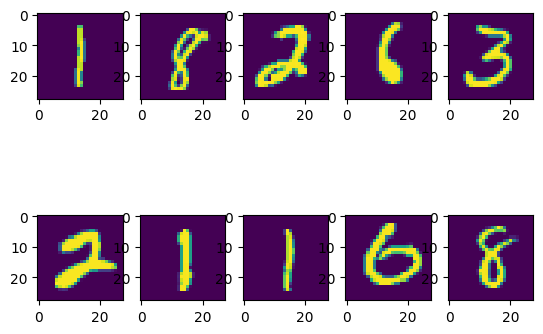

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


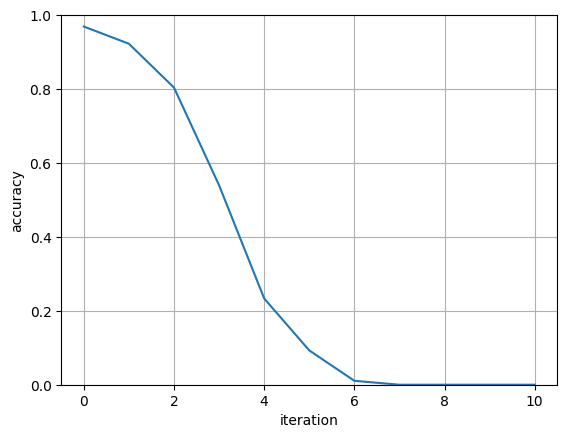

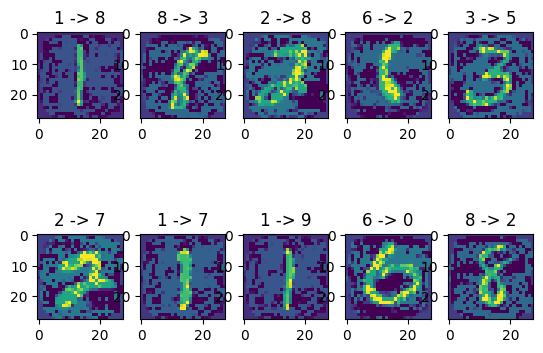

Accuracy: 0.9690999984741211 -> 0.0


In [9]:
acc_list_ntk, grad_list_ntk = ntk_adv(epsilon=3e-3)

In [10]:
def gauss_adv(num_iter=10, epsilon=1e-3, plot=True):
    @jax.jit
    def kernel_fn(x, y, theta1=1., theta2=1.):
        k = (
            jnp.sum(jnp.square(x), axis=1).reshape(-1, 1)
            + jnp.sum(jnp.square(y), axis=1)
            - 2 * x @ y.T
        )
        return theta1 * jnp.exp(-0.5 / theta2 * k)

    K_train = jax.device_get(kernel_fn(train_x, train_x))
    K_inv = jnp.linalg.inv(K_train + K_train.shape[0] * 1e-5 * jnp.eye(K_train.shape[0]))
    del K_train

    grad_list = []

    @jax.jit
    def predict(x_test):
        K_new = kernel_fn(train_x, x_test)
        return K_new.T @ K_inv @ train_y

    @jax.jit
    def loss_fn(test_x, test_y):
        pred = predict(x_test=test_x)
        loss = optax.softmax_cross_entropy(pred, test_y).mean()
        return loss

    @jax.jit
    def evaluate(test_x, test_y):
        pred = predict(x_test=test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(test_x, test_y):
        grad = jax.grad(loss_fn)(test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x, grad = update(x, test_y)
        grad_list.append(jax.device_get(grad))
        _, acc = evaluate(x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    del K_inv
    return acc_list, grad_list
    

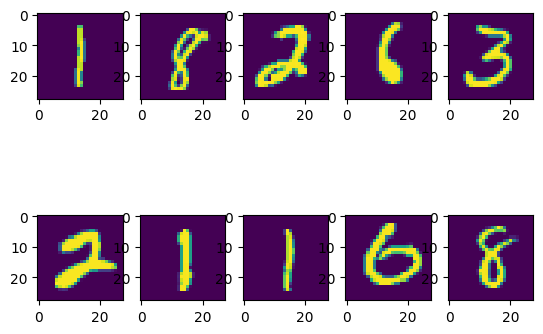

100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


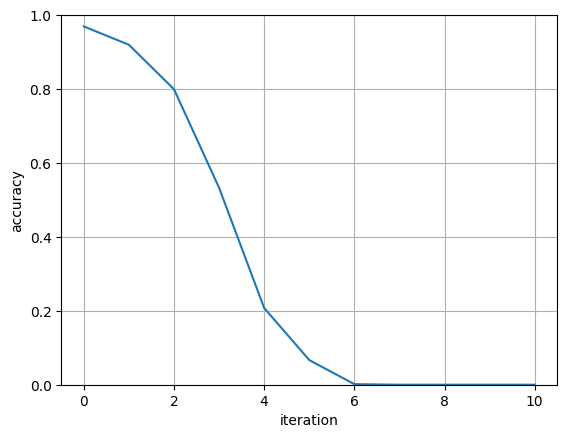

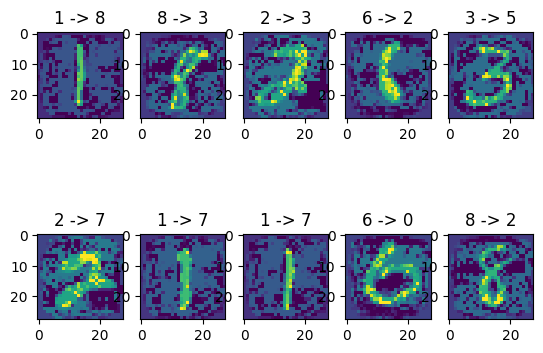

Accuracy: 0.9693999886512756 -> 0.0


In [11]:
acc_list_gauss, grad_list_gauss = gauss_adv(epsilon=3e-3)

In [12]:
def nn_adv(channels, ckpt_dir, num_iter=10, epsilon=1e-3, plot=True):

    init_fn, apply_fn = ostax.serial(
        ostax.Dense(channels),
        ostax.Relu,
        ostax.Dense(NUM_CLASSES)
    )
    
    _, init_params = init_fn(jax.random.PRNGKey(seed=SEED), (-1, 28*28))

    params = restore_checkpoint(ckpt_dir, target=init_params)

    grad_list = []

    @jax.jit
    def loss_fn(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        loss = optax.softmax_cross_entropy(pred, test_y).mean()
        return loss

    @jax.jit
    def evaluate(params, test_x, test_y):
        pred = apply_fn(params, test_x)
        y_pred = jnp.argmax(pred, axis=-1)
        gt = jnp.argmax(test_y, axis=-1)
        accuracy = jnp.mean(y_pred == gt)
        return y_pred, accuracy

    @jax.jit
    def update(params, test_x, test_y):
        grad = jax.grad(loss_fn, argnums=1)(params, test_x, test_y)
        grad = jnp.reshape(grad, test_x.shape)
        x_adv = test_x + epsilon * jnp.sign(grad)
        return x_adv, grad
    
    def plot_grid(x, before=None, after=None):
        cnt = 0
        ncol, nrow = 5, 2
        for i in range(ncol * nrow):
            cnt += 1
            plt.subplot(nrow, ncol, cnt)
            if before is not None and after is not None:
                plt.title(f"{before['pred'][i]} -> {after['pred'][i]}")
            plt.imshow(x[i].reshape(28, 28, 1))
        plt.show()
        plt.close()
    
    x = test_x_copy.copy()
    if plot:
        plot_grid(x[:10])
    
    pred, acc = evaluate(params, x, test_y)
    before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    acc_list = [acc]
    for step in tqdm(range(num_iter)):
        x, grad = update(params, x, test_y)
        grad_list.append(jax.device_get(grad))
        _, acc = evaluate(params, x, test_y)
        acc_list.append(acc)

    pred, acc = evaluate(params, x, test_y)
    after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

    if plot:
        plt.plot(acc_list)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.ylim(0, 1)
        plt.grid()
        plt.show()
        plt.close()

    if plot:
        plot_grid(x[:10], before, after)

    print(f'Accuracy: {before["acc"]} -> {after["acc"]}')
    return acc_list, grad_list

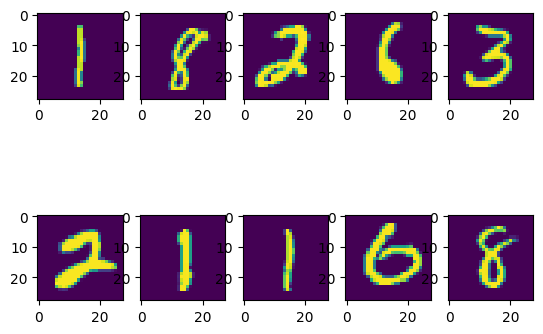

100%|██████████| 10/10 [00:00<00:00, 19.98it/s]


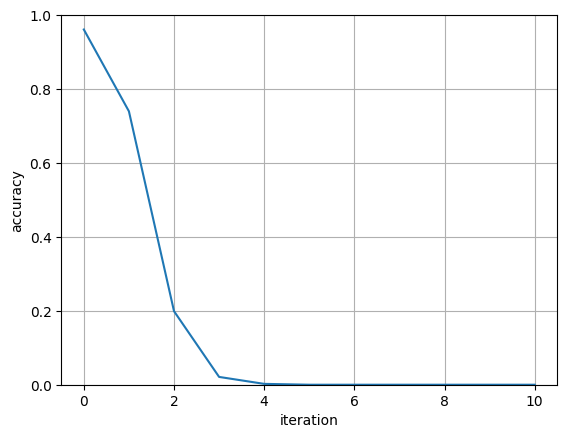

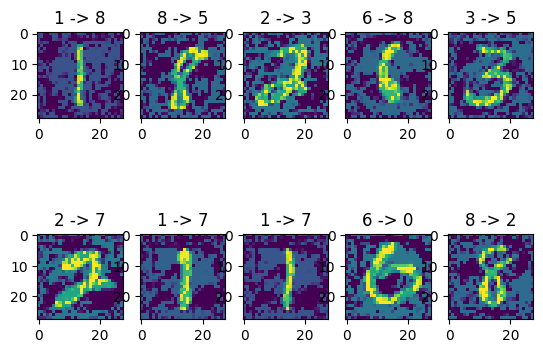

Accuracy: 0.9610999822616577 -> 0.0


In [13]:
channels = 256
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_256, grad_list_256 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

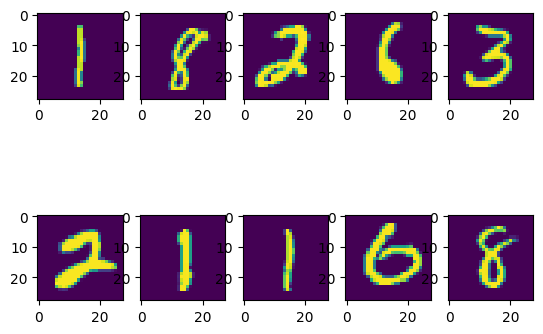

100%|██████████| 10/10 [00:00<00:00, 20.01it/s]


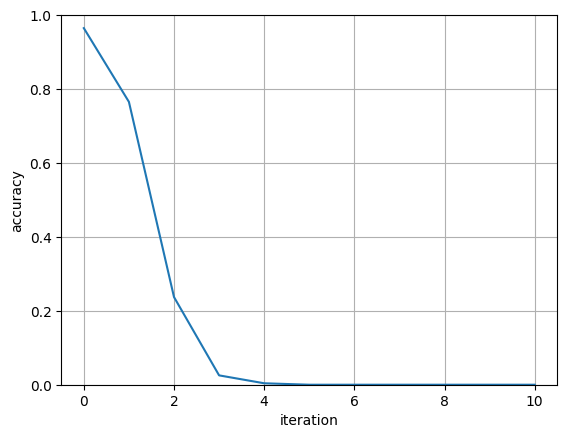

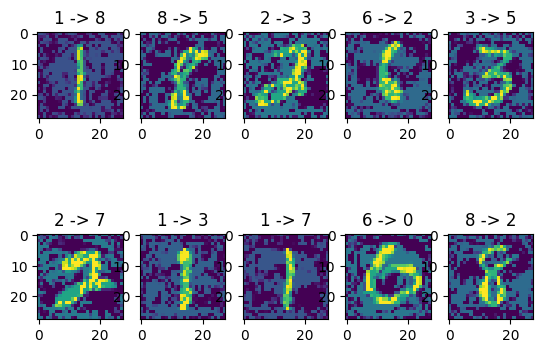

Accuracy: 0.9648000001907349 -> 0.0


In [14]:
channels = 512
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_512, grad_list_512 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

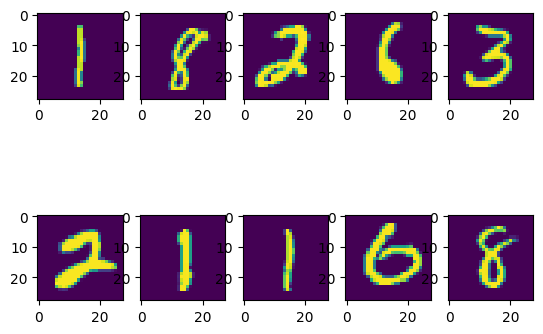

100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


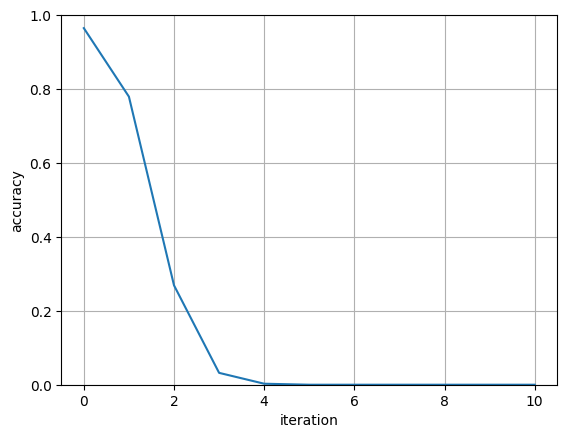

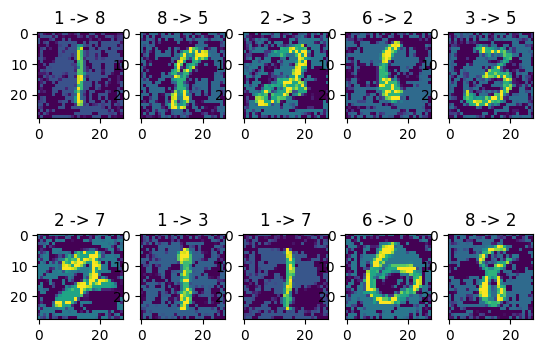

Accuracy: 0.9648000001907349 -> 0.0


In [15]:
channels = 1024
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_1024, grad_list_1024 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

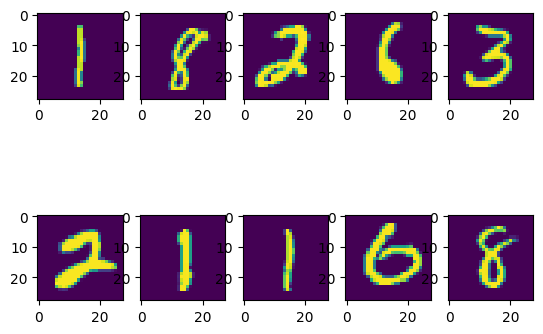

100%|██████████| 10/10 [00:00<00:00, 17.38it/s]


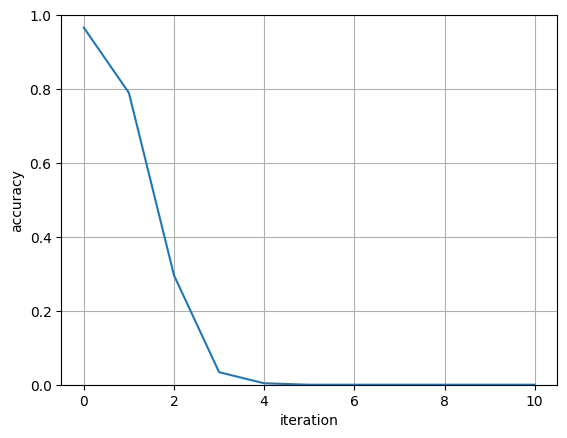

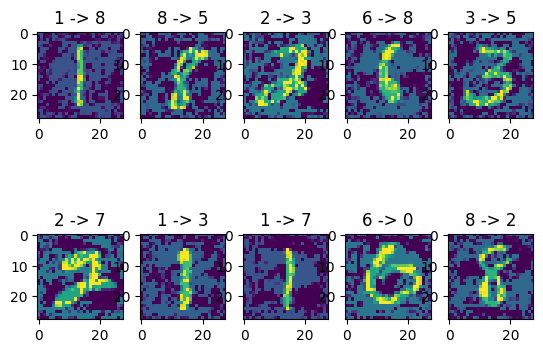

Accuracy: 0.9660999774932861 -> 0.0


In [16]:
channels = 2048
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_2048, grad_list_2048 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

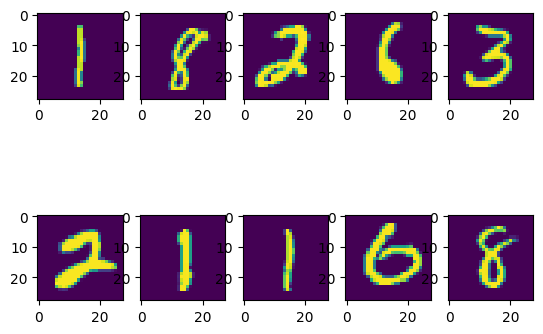

100%|██████████| 10/10 [00:00<00:00, 14.69it/s]


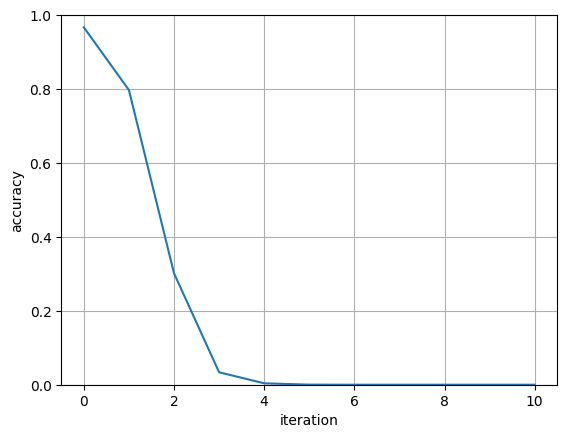

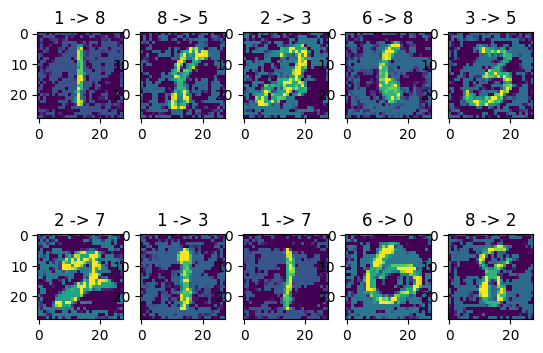

Accuracy: 0.9668999910354614 -> 0.0


In [17]:
channels = 4096
ckpt_dir = f"ckpt/mnist/channel_{channels}"
acc_list_4096, grad_list_4096 = nn_adv(channels, ckpt_dir, epsilon=3e-3)

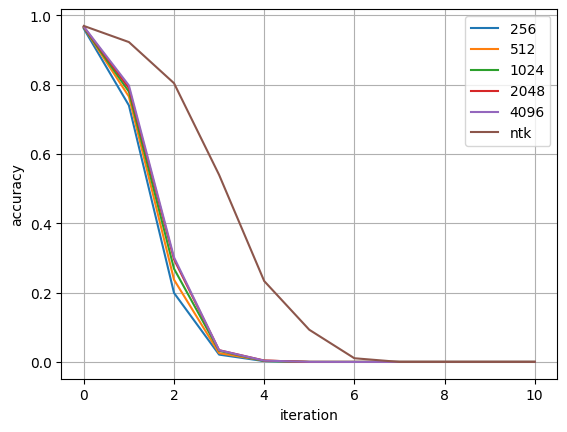

In [18]:
plt.plot(acc_list_256, label='256')
plt.plot(acc_list_512, label='512')
plt.plot(acc_list_1024, label='1024')
plt.plot(acc_list_2048, label='2048')
plt.plot(acc_list_4096, label='4096')
plt.plot(acc_list_ntk, label='ntk')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

In [26]:
label_list = ['256', '512', '1024', '2048', '4096', 'ntk', 'gauss']
epsilons = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 7.5e-3]
acc_dict = {str(eps): {l: None for l in label_list} for eps in epsilons}
for epsilon in epsilons:
    print(epsilon)
    for label in label_list:
        if label == 'ntk':
            acc_list = ntk_adv(epsilon=epsilon, plot=False)
        elif label == 'gauss':
            acc_list = gauss_adv(epsilon=epsilon, plot=False)
        else:
            channels = int(label)
            ckpt_dir = f'ckpt/mnist/channel_{channels}'
            acc_list = nn_adv(channels, ckpt_dir, epsilon=epsilon, plot=False)
        acc_dict[str(epsilon)][label] = acc_list

0.0001


100%|██████████| 10/10 [00:00<00:00, 22.11it/s]


Accuracy: 0.9610999822616577 -> 0.9238999485969543


100%|██████████| 10/10 [00:00<00:00, 19.62it/s]


Accuracy: 0.9648000001907349 -> 0.9284999966621399


100%|██████████| 10/10 [00:00<00:00, 23.61it/s]


Accuracy: 0.9648000001907349 -> 0.9302999973297119


100%|██████████| 10/10 [00:00<00:00, 22.12it/s]


Accuracy: 0.9660999774932861 -> 0.9330999851226807


100%|██████████| 10/10 [00:00<00:00, 19.24it/s]


Accuracy: 0.9668999910354614 -> 0.9353999495506287


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Accuracy: 0.9690999984741211 -> 0.9573999643325806


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Accuracy: 0.9693999886512756 -> 0.958299994468689
0.0002


100%|██████████| 10/10 [00:00<00:00, 24.02it/s]


Accuracy: 0.9610999822616577 -> 0.8562999963760376


100%|██████████| 10/10 [00:00<00:00, 23.60it/s]


Accuracy: 0.9648000001907349 -> 0.8666999936103821


100%|██████████| 10/10 [00:00<00:00, 23.25it/s]


Accuracy: 0.9648000001907349 -> 0.8723999857902527


100%|██████████| 10/10 [00:00<00:00, 21.99it/s]


Accuracy: 0.9660999774932861 -> 0.8795999884605408


100%|██████████| 10/10 [00:00<00:00, 18.88it/s]


Accuracy: 0.9668999910354614 -> 0.8805999755859375


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9690999984741211 -> 0.9429999589920044


100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


Accuracy: 0.9693999886512756 -> 0.9417999982833862
0.0005


100%|██████████| 10/10 [00:00<00:00, 24.45it/s]


Accuracy: 0.9610999822616577 -> 0.34059998393058777


100%|██████████| 10/10 [00:00<00:00, 24.65it/s]


Accuracy: 0.9648000001907349 -> 0.4052000045776367


100%|██████████| 10/10 [00:00<00:00, 23.97it/s]


Accuracy: 0.9648000001907349 -> 0.4244000017642975


100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Accuracy: 0.9660999774932861 -> 0.4558999836444855


100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


Accuracy: 0.9668999910354614 -> 0.46549999713897705


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9690999984741211 -> 0.852899968624115


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


Accuracy: 0.9693999886512756 -> 0.8496999740600586
0.001


100%|██████████| 10/10 [00:00<00:00, 24.56it/s]


Accuracy: 0.9610999822616577 -> 0.0072999997064471245


100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


Accuracy: 0.9648000001907349 -> 0.010300000198185444


100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Accuracy: 0.9648000001907349 -> 0.01119999960064888


100%|██████████| 10/10 [00:00<00:00, 22.21it/s]


Accuracy: 0.9660999774932861 -> 0.0139999995008111


100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


Accuracy: 0.9668999910354614 -> 0.0142000000923872


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9690999984741211 -> 0.4195999801158905


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


Accuracy: 0.9693999886512756 -> 0.4097999930381775
0.002


100%|██████████| 10/10 [00:00<00:00, 23.94it/s]


Accuracy: 0.9610999822616577 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 24.49it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 23.72it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


Accuracy: 0.9660999774932861 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 19.24it/s]


Accuracy: 0.9668999910354614 -> 0.0


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Accuracy: 0.9690999984741211 -> 0.00019999999494757503


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Accuracy: 0.9693999886512756 -> 0.0
0.005


100%|██████████| 10/10 [00:00<00:00, 24.00it/s]


Accuracy: 0.9610999822616577 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 23.91it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 23.84it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 22.30it/s]


Accuracy: 0.9660999774932861 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 18.93it/s]


Accuracy: 0.9668999910354614 -> 0.0


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Accuracy: 0.9690999984741211 -> 0.0


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


Accuracy: 0.9693999886512756 -> 0.0
0.0075


100%|██████████| 10/10 [00:00<00:00, 24.39it/s]


Accuracy: 0.9610999822616577 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 21.75it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 23.70it/s]


Accuracy: 0.9648000001907349 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 22.07it/s]


Accuracy: 0.9660999774932861 -> 0.0


100%|██████████| 10/10 [00:00<00:00, 18.93it/s]


Accuracy: 0.9668999910354614 -> 0.0


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Accuracy: 0.9690999984741211 -> 0.0


100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


Accuracy: 0.9693999886512756 -> 0.0


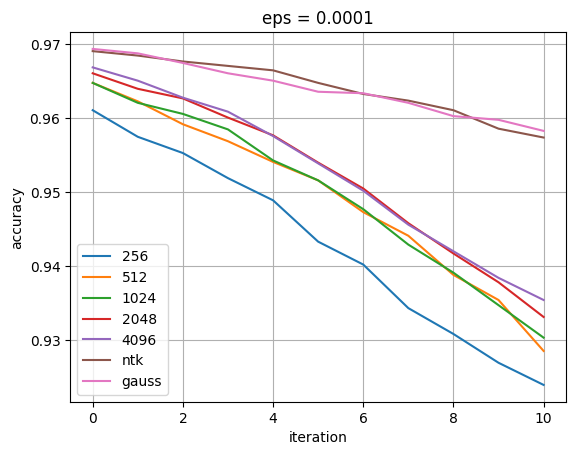

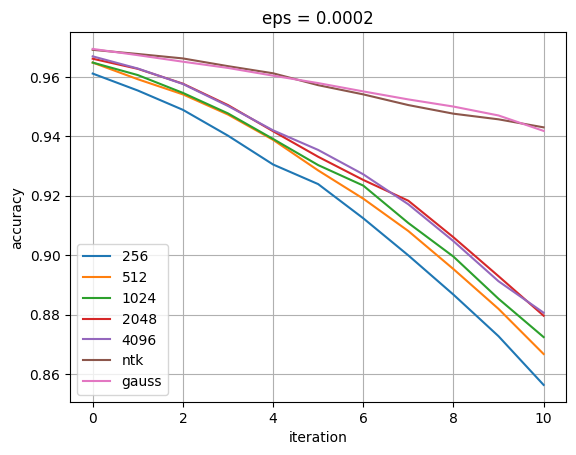

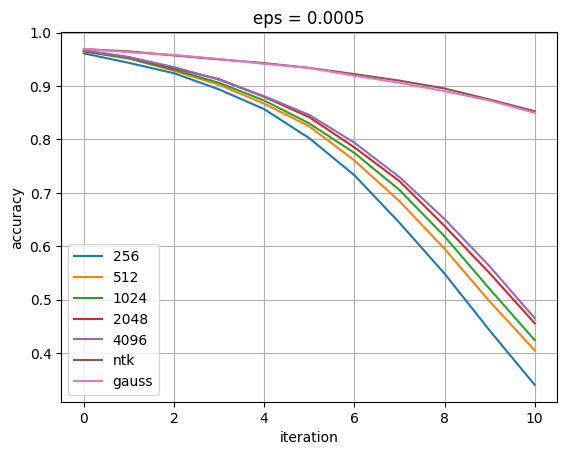

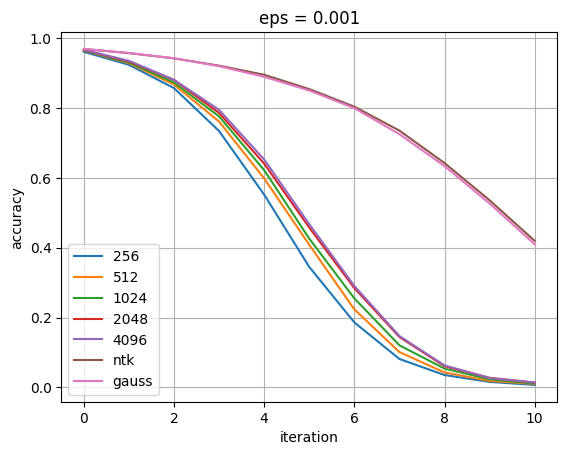

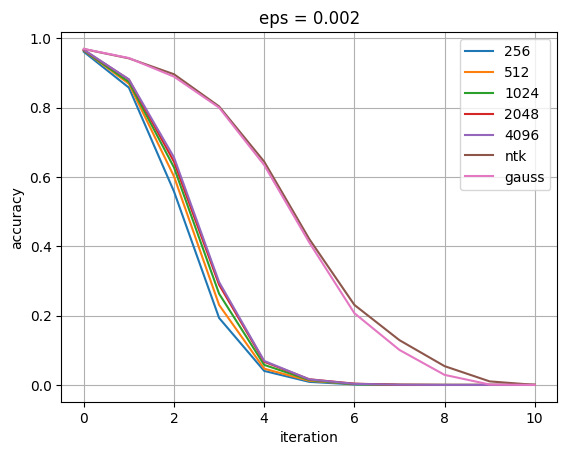

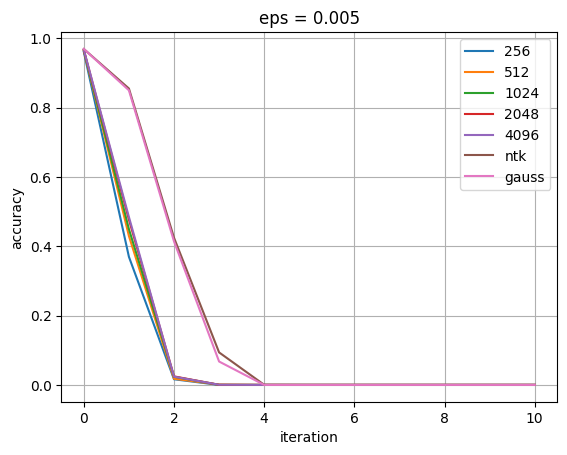

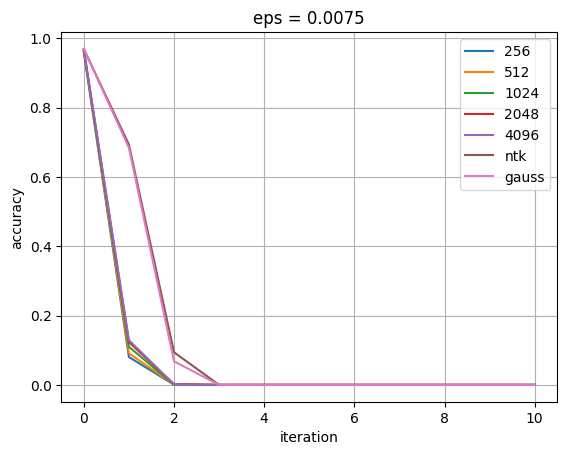

In [27]:
def plot_per_epsilon(epsilon):
    for k, v in acc_dict[str(epsilon)].items():
        plt.plot(v[0], label=k)
    plt.title(f'eps = {epsilon}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for eps in epsilons:
    plot_per_epsilon(eps)

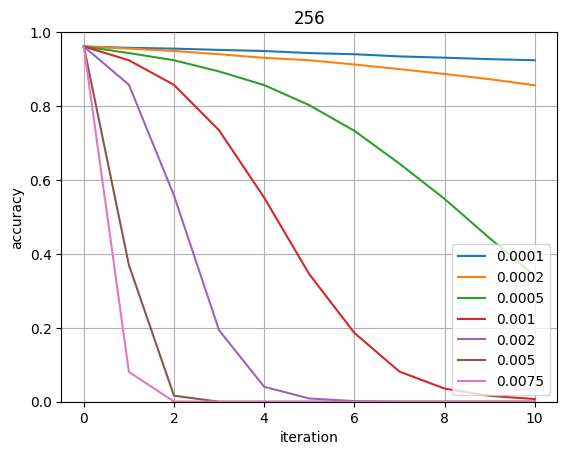

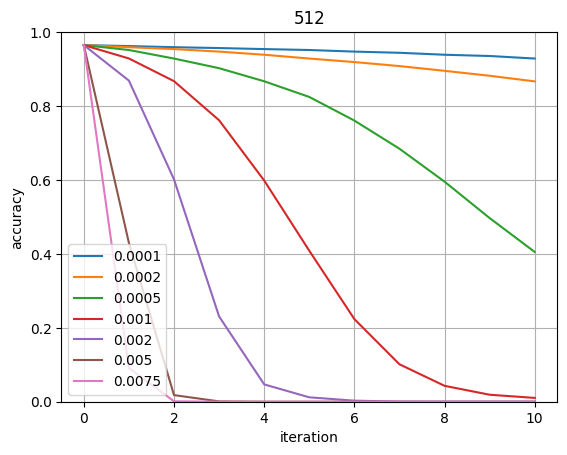

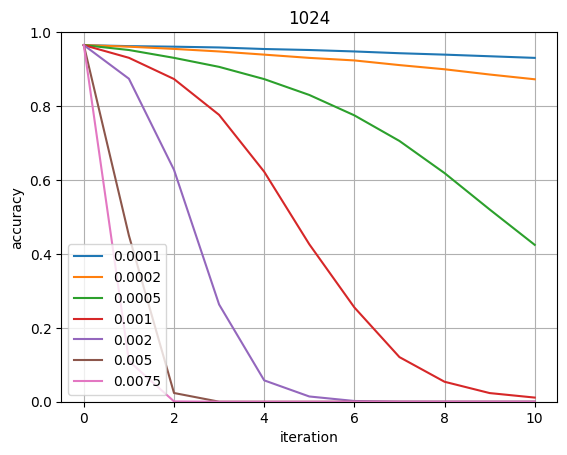

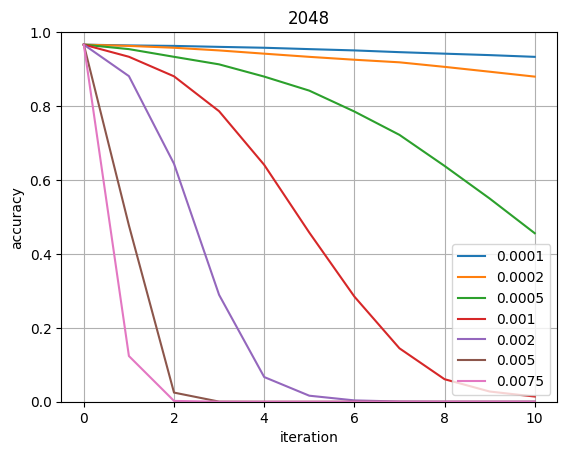

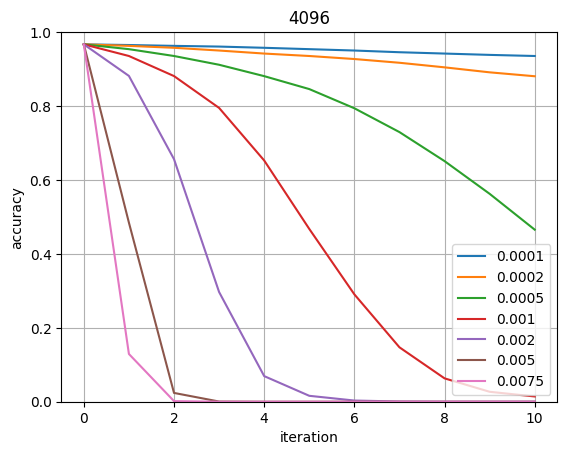

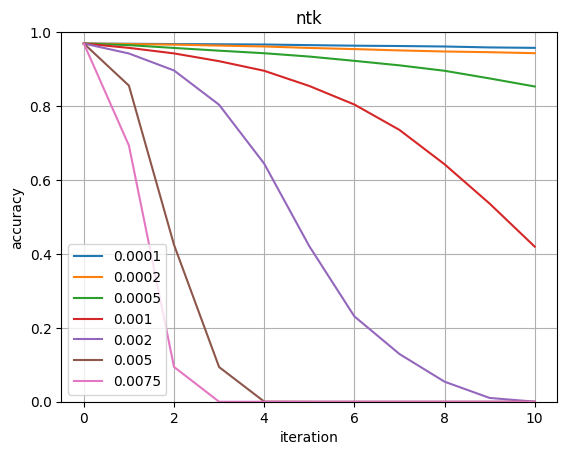

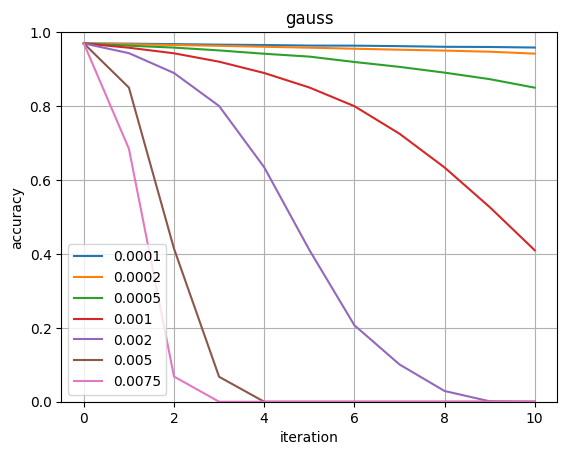

In [28]:
def plot_per_label(label, d):
    for k, v in d.items():
        plt.plot(v[0], label=k)
    plt.title(f'{label}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d)

In [22]:
def cos_sim_batch(x, y):
    def cos_sim(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    score = np.mean([cos_sim(v1, v2) for v1, v2 in zip(x, y)])
    return score

In [23]:
nn_grad = {
    '256': grad_list_256,
    '512': grad_list_512,
    '1024': grad_list_1024,
    '2048': grad_list_2048,
    '4096': grad_list_4096
}

def plot_cos_sim(title, kernel_grad, nn_grad_dict):
    for k, v in nn_grad_dict.items():
        sim = [cos_sim_batch(ker, nn) for ker, nn in zip(kernel_grad, v)]
        plt.plot(sim, label=k)
    plt.title(f'{title}')
    plt.xlabel('iteration')
    plt.ylabel('similarity')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

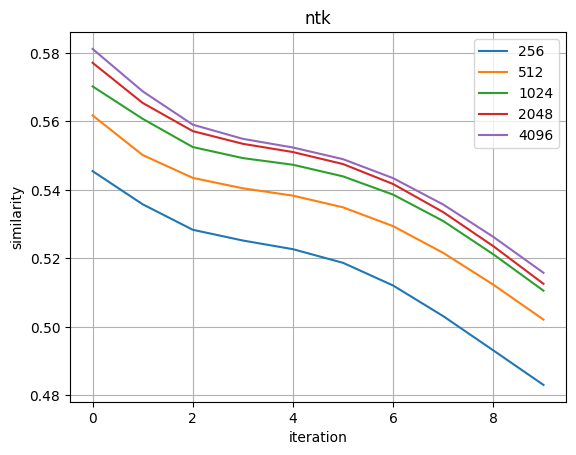

In [24]:
plot_cos_sim('ntk', grad_list_ntk, nn_grad)

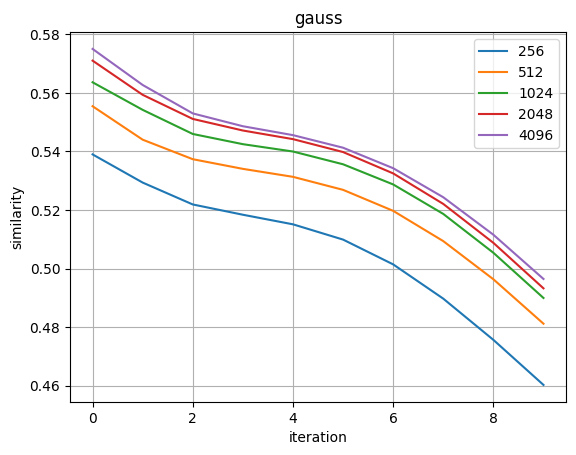

In [25]:
plot_cos_sim('gauss', grad_list_gauss, nn_grad)

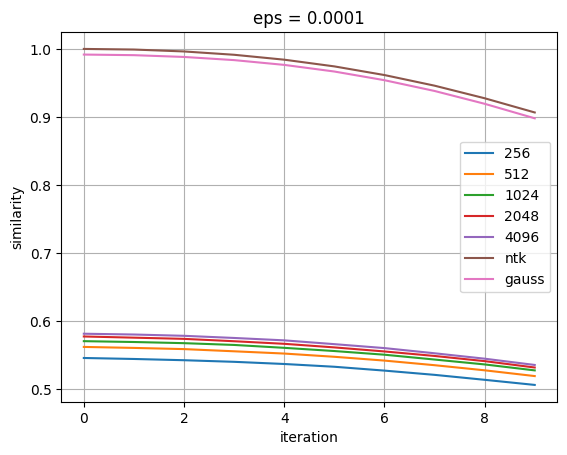

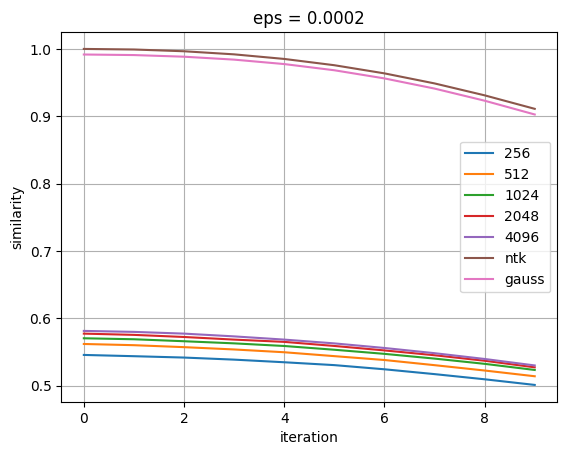

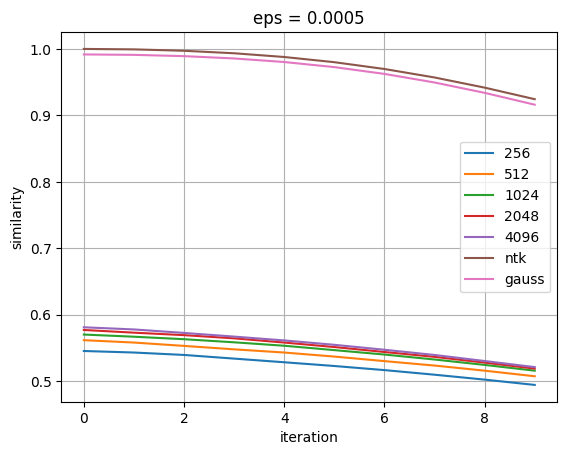

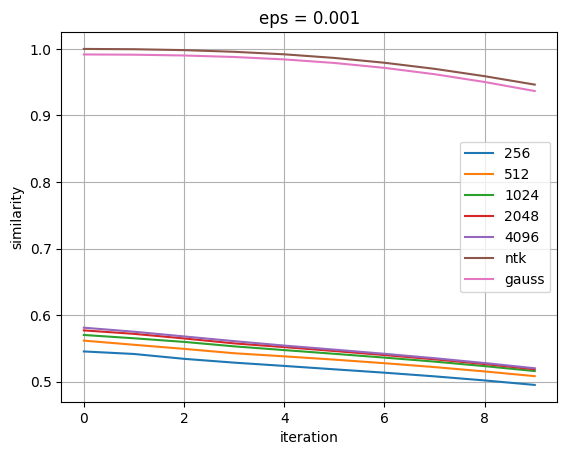

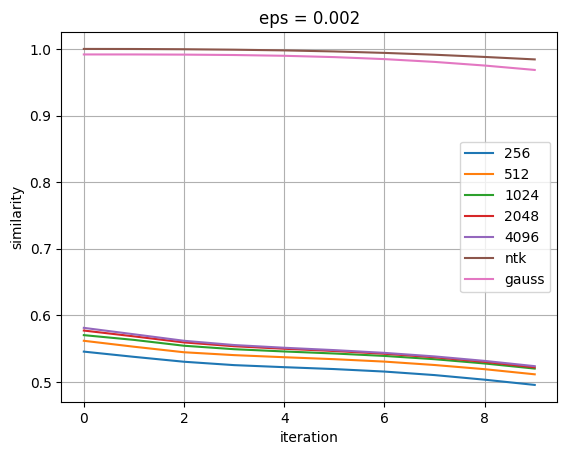

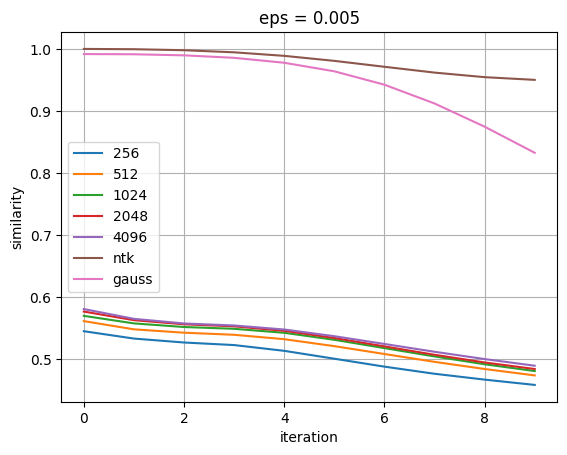

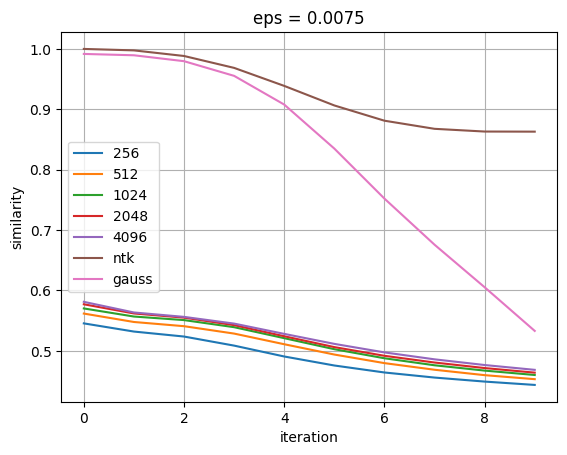

In [30]:
def plot_sim_per_epsilon(epsilon, kernel_grad):
    for k, v in acc_dict[str(epsilon)].items():
        sim = [cos_sim_batch(ker, nn) for ker, nn in zip(kernel_grad, v[1])]
        plt.plot(sim, label=k)
    plt.title(f'eps = {epsilon}')
    plt.xlabel('iteration')
    plt.ylabel('similarity')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for eps in epsilons:
    plot_sim_per_epsilon(eps, grad_list_ntk)

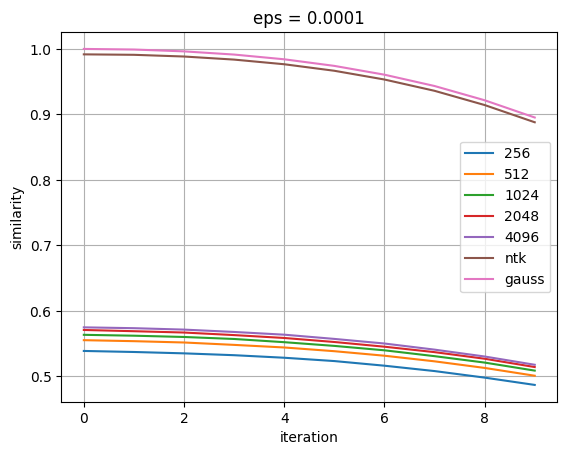

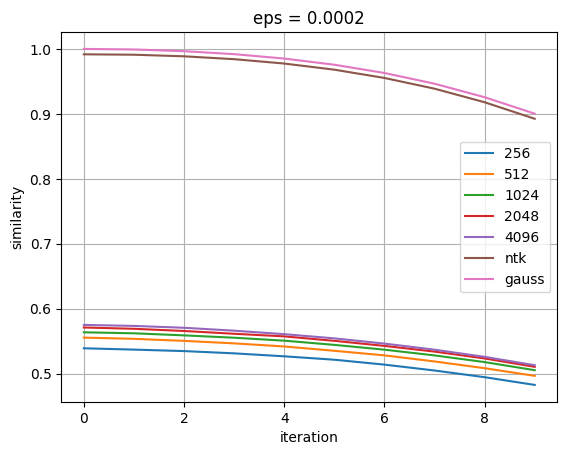

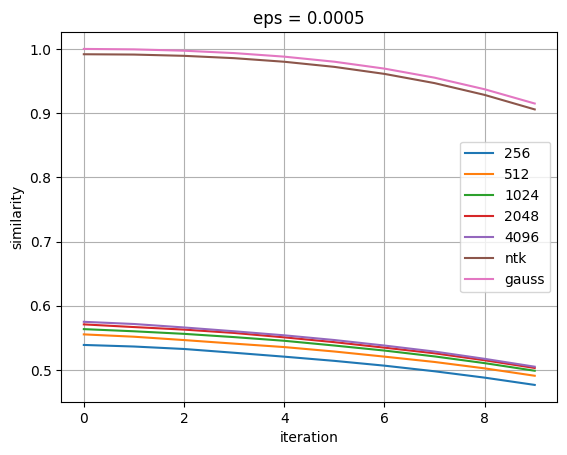

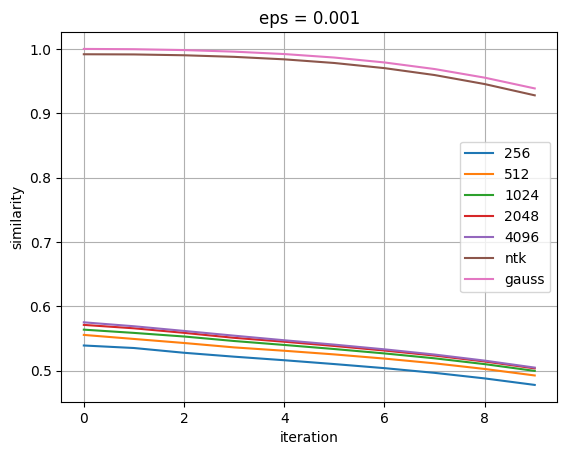

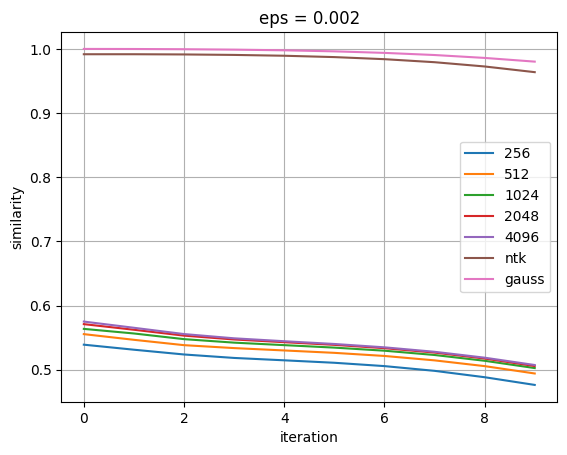

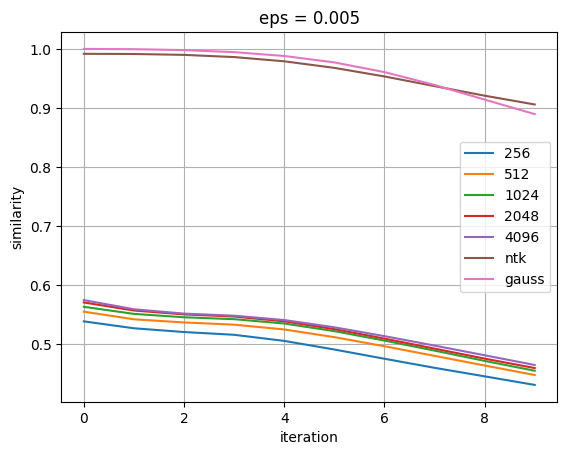

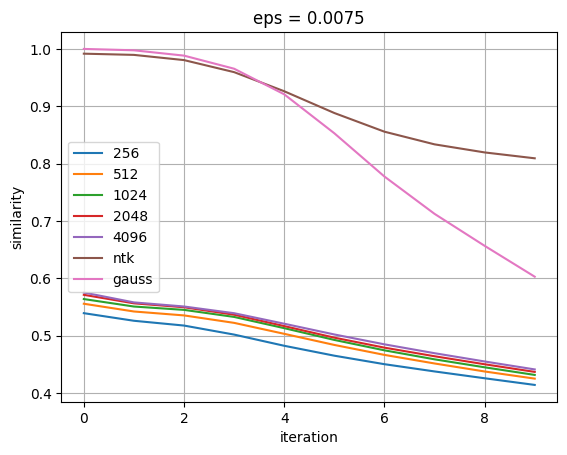

In [31]:
for eps in epsilons:
    plot_sim_per_epsilon(eps, grad_list_gauss)

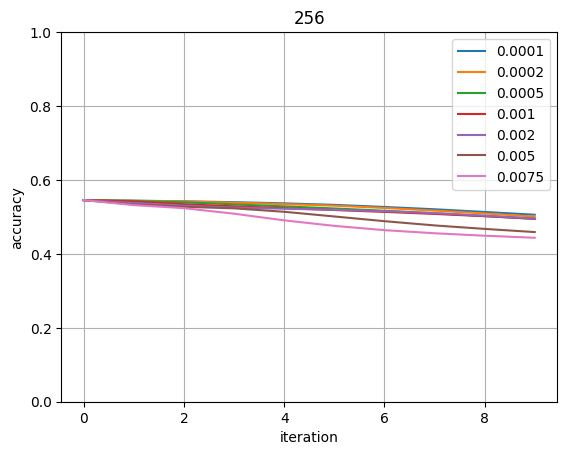

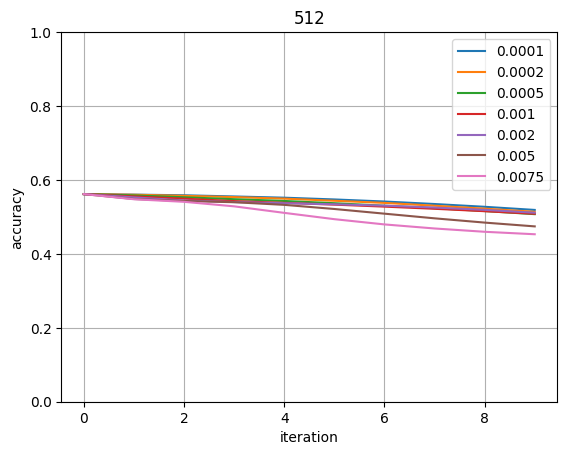

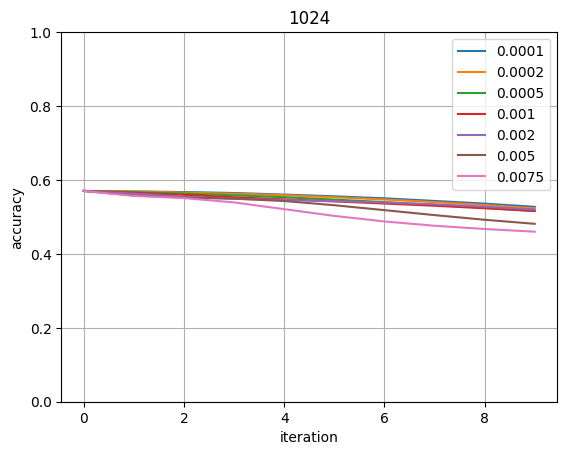

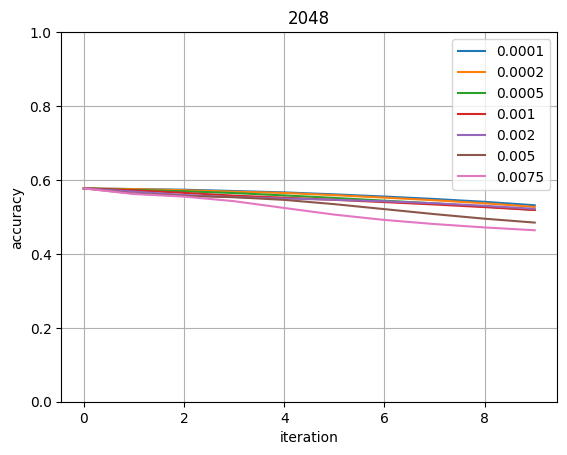

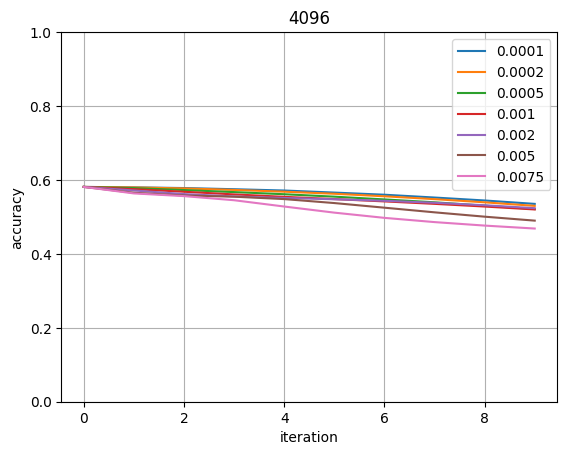

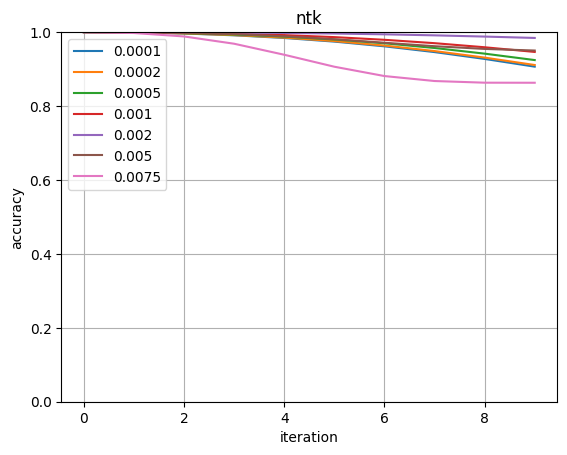

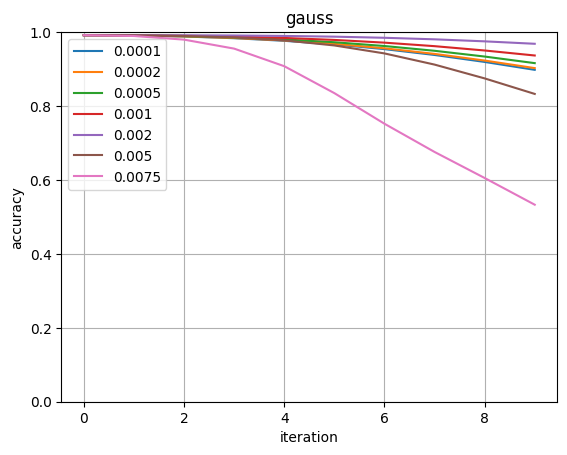

In [32]:
def plot_per_label(label, d, kernel_grad):
    for k, v in d.items():
        sim = [cos_sim_batch(ker, nn) for ker, nn in zip(kernel_grad, v[1])]
        plt.plot(sim, label=k)
    plt.title(f'{label}')
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d, grad_list_ntk)

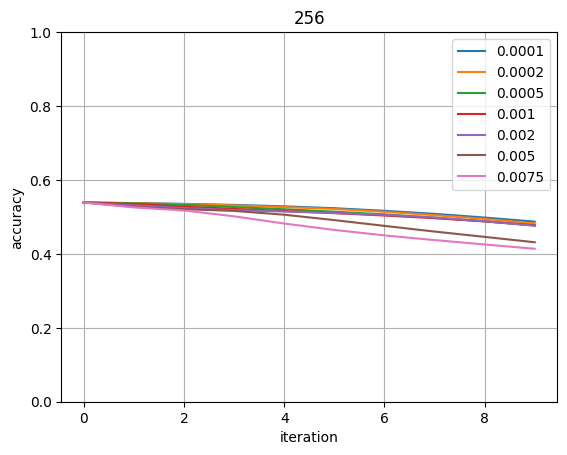

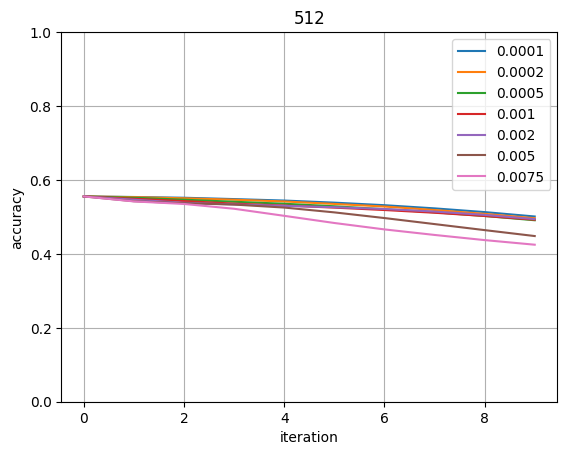

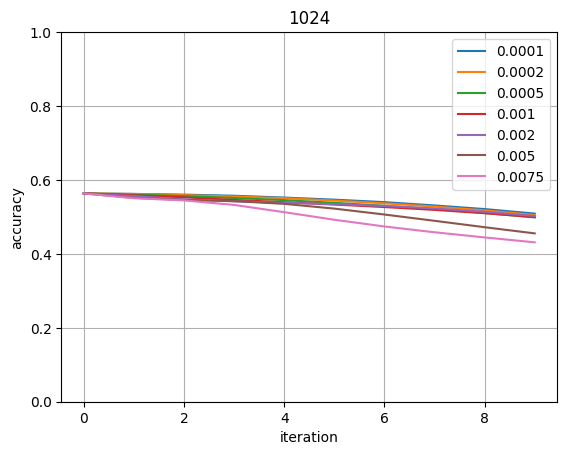

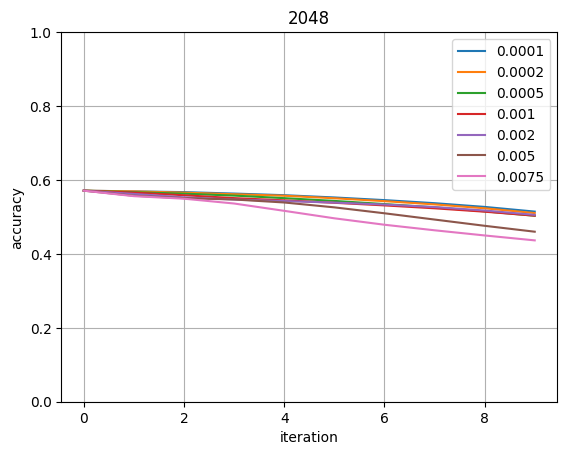

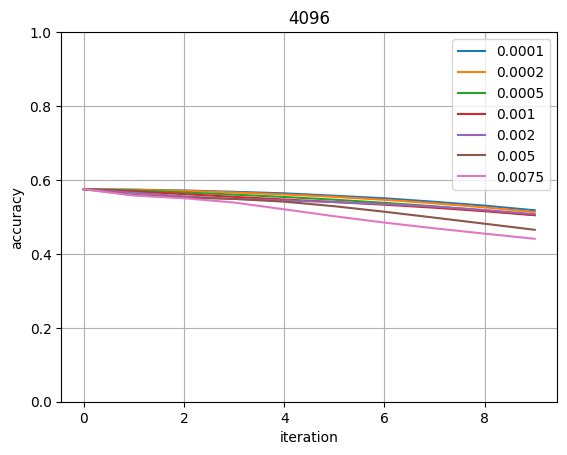

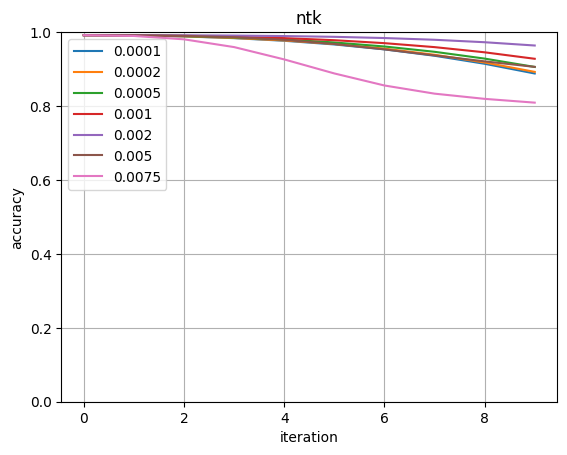

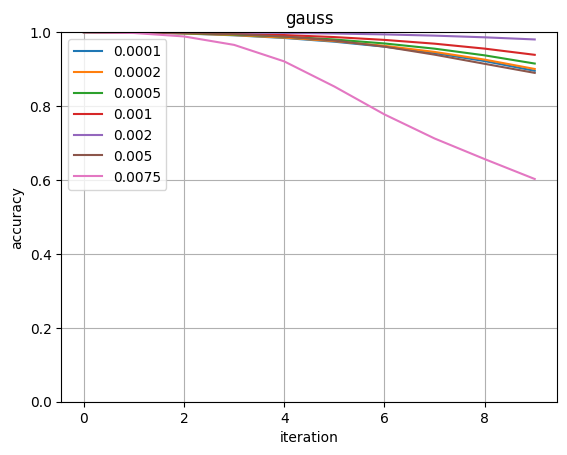

In [33]:
for label in label_list:
    d = {k: v[label] for k, v in acc_dict.items()}
    plot_per_label(label, d, grad_list_gauss)

# Accuracy